# **Métodos basados en árboles**

In [1]:
# Importamos paquetes necesarios
import sklearn as s
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
person_df = pd.read_csv('https://raw.githubusercontent.com/rdambrosioz/aa_2021/main/500_Person_Gender_Height_Weight_Index.csv')

In [4]:
features = person_df.columns[0:-1]
person_df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


(Gender    object
 Height     int64
 Weight     int64
 Index      int64
 dtype: object,
 count    500.000000
 mean       3.748000
 std        1.355053
 min        0.000000
 25%        3.000000
 50%        4.000000
 75%        5.000000
 max        5.000000
 Name: Index, dtype: float64,
 <AxesSubplot:>)

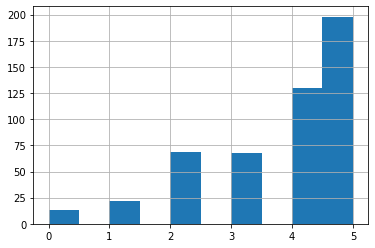

In [5]:
person_df.dtypes, person_df['Index'].describe(), person_df['Index'].hist()

Imaginamos que queremos predecir si la persona es, o no, obesa. Según la descripción del dataset, las personas con indice de 4 o 5 son obesas, por lo que podríamos crear una variable que refleje esto:

In [6]:
person_df['obese'] = (person_df.Index >= 4).astype('int').astype('str')
person_df.drop('Index', axis = 1, inplace = True)

Eliminamos la columna Index, en su lugar creamos la columna obese, con un 1 si el index era de 4 o 5, 0 en caso contrario

In [7]:
person_df.head()

,Gender,Height,Weight,obese
0,Male,174,96,1
1,Male,189,87,0
2,Female,185,110,1
3,Female,195,104,0
4,Male,149,61,0


En ese caso, un árbol de decisión nos diría distintas reglas, como por ejemplo, que si el peso de la persona es superior a 100kg, lo más probable es que esa persona sea obesa. Sin embargo, ese corte no será preciso: habrá personas que pesen 100kg que no sean obesas. Así pues, el árbol de decisión sigue creando más ramas que generan nuevas condiciones para ir “afinando” nuestras predicciones.

### Indice de Gini y la Entropía

Como en todos los algoritmos, la función de coste es la base del algoritmo. En el caso de los árboles de decisión, existen dos principales funciones de coste: el índice de Gini y la entropía.

In [8]:
# Calculo del indice de Gini

def gini_impurity(y):
  
    if isinstance(y, pd.Series):
        p = y.value_counts()/y.shape[0]
        gini = 1-np.sum(p**2)
        return(gini)
    else:
        raise('Object must be a Pandas Series.')

gini_impurity(person_df.Gender)

0.4998

El rango del indice de Gini va de 0 a 1.

Como vemos, el índice de Gini para la variable Género es muy cercano al 0,5. Esto indica que la variable Género es muy impura, es decir, que los resultados del corte no son buenos.

In [9]:
def entropy(y):
  
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)

  else:
    raise('Object must be a Pandas Series.')

entropy(person_df.Gender)

0.9997114388674198

El rango de la entropia va de 0 a 1. Los valores cercanos a cero son menos impuros que aquellos que se acercan al 1.

Como vemos, nos da un valor muy cercano al 1, lo cual denota una impureza similar a lo que indice la impureza de Gini.

### Cómo elegir los cortes para nuestro árbol de decisión

Como hemos visto, los cortes se comparan mediante la impureza. Por tanto, nos interesa comparar aquellos cortes que menor impureza generan. Para ello, se utiliza el Information Gain. Esta métrica indica la mejora al hacer diferentes particiones y se suele utilizar con la entropía.

El cálculo del Information Gain dependerá de si se trata de un árbol de decisión de clasificación o de regresión. 

In [10]:
def variance(y):
  
  if(len(y) == 1):
    return 0
  else:
    return y.var()

def information_gain(y, mask, func=entropy):
  # Mask: split choice
  # func: function to be used to calculate Information Gain in case os classification.
    a = sum(mask)
    b = mask.shape[0] - a
  
    if(a == 0 or b ==0): 
        ig = 0
  
    else:
        if y.dtypes != 'O':
            ig = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
        else:
            ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
    
    return ig

In [11]:
information_gain(person_df['obese'], person_df['Gender'] == 'Male')

0.0005506911187600494

¿Cómo elegimos cuál es el mejor split en las variables numéricas?

### Cómo calcular el mejor split para una variable

Para calcular el mejor split de una variable numérica, lo primero se deben obtener todos posibles valores que está tomando la variable. Una vez tenemos las opciones, para cada opción calcularemos el Information Gain usando como filtro si el valor es inferior a ese valor.

En caso de que contemos con variables categóricas, la idea es la misma, solo que en este caso deberemos calcular el Information Gain para todas las combinaciones posibles de esa variable, excluyendo la opción que incluye a todas las opciones.

Así pues, una vez tengamos todos los splits, nos quedaremos con aquel split que genere un mayor Information Gain.

In [12]:
import itertools

def categorical_options(a):
    
    a = a.unique()
    opciones = []
  
    for L in range(0, len(a)+1):
        for subset in itertools.combinations(a, L):
            subset = list(subset)
            opciones.append(subset)

    return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):

    split_value = []
    ig = [] 

    numeric_variable = True if x.dtypes != 'O' else False

    # Create options according to variable type
    if numeric_variable:
        options = x.sort_values().unique()[1:]
    else: 
        options = categorical_options(x)

    # Calculate ig for all values
    for val in options:
        mask =   x < val if numeric_variable else x.isin(val)
        val_ig = information_gain(y, mask, func)
    
    # Append results
    ig.append(val_ig)
    split_value.append(val)

    # Check if there are more than 1 results if not, return False
    if len(ig) == 0:
        return(None,None,None, False)
    else:
        # Get results with highest IG
        best_ig = max(ig)
        best_ig_index = ig.index(best_ig)
        best_split = split_value[best_ig_index]
        return(best_ig,best_split,numeric_variable, True)

weight_ig, weight_slpit, _, _ = max_information_gain_split(person_df['Weight'], person_df['obese'],)  


print(
  "El mejor split para Weight es cuando la variable es inferior a ",
  weight_slpit,"\nEl Information Gain para ese corte es:", weight_ig
)

El mejor split para Weight es cuando la variable es inferior a  160 
El Information Gain para ese corte es: 0.007353814315463637


### Cómo elegir el mejor split

Como he comentado previamente, el mejor split será aquel que genere un Information Gain más alto. Para conocerlo, simplemente tendremos que calcular el Information Gain para cada una de las variables predictoras del modelo.

In [13]:
person_df.drop('obese', axis= 1).apply(max_information_gain_split, y = person_df['obese'])

,Gender,Height,Weight
0,0.000551,0.001877,0.007354
1,[Female],199,160
2,False,True,True
3,True,True,True


Como vemos, la variable con mayor Information Gain es Weight. Por tanto, será la variable que utilicemos primero para hacer el split. Además, tenemos también el valor sobre el cual se debe realizar el split: 103.